In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [25]:
def mouth_extractor(file_path: str, scale_factor=1.3, min_neighbors=5, mouth_size=(140, 70)) -> None:
    """
    Extract the mouth from the video and save as an npy file
    :param file_path: Path to the video file
    :param scale_factor: Parameter specifying how much the image size is reduced at each image scale
    :param min_neighbors: Parameter specifying how many neighbors each candidate rectangle should have to retain it
    :param mouth_size: Size of the extracted mouth region
    :return: None
    """
    base_path = file_path.split('.')[0]
    # if not os.path.exists(base_path + '.npy'):
    if file_path.endswith('.mpg'):
        cap = cv2.VideoCapture(file_path)
        if not cap.isOpened():
            raise Exception("Error: Could not open video.")

        frames = []
        for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
            ret, frame = cap.read()
            if not ret:
                raise Exception("Error: Could not read frame.")
            # 参数分别为低阈值和高阈值
            faces = face_cascade.detectMultiScale(frame, scale_factor, min_neighbors)
            if len(faces) == 0:
                continue
            for (x, y, w, h) in faces:
                mouth_roi = frame[y + int(h / 2):y + h, x:x + w, ]
                mouth_roi = cv2.resize(mouth_roi, mouth_size)
                mouth_roi = cv2.cvtColor(mouth_roi, cv2.COLOR_BGR2GRAY)
                frames.append(mouth_roi)

        cap.release()
        # Normalize frames
        frames = np.array(frames, dtype=np.float32)
        mean = np.mean(frames)
        std = np.std(frames)
        # Normalize frames
        frames = (frames - mean) / std  # Broadcasting subtraction and division
        # Save as npy file
        np.save(base_path + '.npy', frames)
        return frames
    else:
        raise Exception("Error: File format not supported.")

In [21]:
frames_tensor = mouth_extractor('/Users/zhenyili/research project/src/lipNet/data/s1/bbbmzn.mpg')
print(frames_tensor.shape)
# show the first 10 frames the np shape is (75, 1, 70, 140)
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
frames_tensor = np.clip(frames_tensor, 0, 1)
# print(frames_tensor[0])
for i in range(4):
    ax[i].imshow(frames_tensor[i])
    # ax[i].axis('off')  # no axes for this plot



Exception: Error: Could not open video.

In [27]:
frames_tensor = mouth_extractor('/Users/zhenyili/research project/src/lipNet/data/s1/bbbmzn.mpg')
print(frames_tensor.shape)
# show the first 10 frames the np shape is (75, 1, 70, 140)
fig, ax = plt.subplots(1, 4, figsize=(20, 10))
frames_tensor = np.clip(frames_tensor, 0, 1)
# print(frames_tensor[0])
for i in range(4):
    ax[i].imshow(frames_tensor[i])
    # ax[i].axis('off')  # no axes for this plot



Exception: Error: Could not open video.

In [24]:

# from utils import mouth_extractor

frames_tensor = mouth_extractor('/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s1/bbbmzn.mpg')
# show the first 10 frames
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for i in range(3):
    ax[i].imshow(frames_tensor[i + 30])
    # ax[i].axis('off')  # no axes for this plot


error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<1>; VDcn = cv::impl::{anonymous}::Set<2>; VDepth = cv::impl::{anonymous}::Set<0>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 3


In [4]:
np.load('/Users/zhenyili/research project/src/lipNet/data/s1/.npy').shape

FileNotFoundError: [Errno 2] No such file or directory: '/Users/zhenyili/research project/src/lipNet/data/s1/bbbmzn.npy'

In [26]:
np.load('/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s1/bbbmzn.npy').shape

(75, 70, 140)

In [27]:
frame = np.load('/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/s1/bbbmzn.npy')

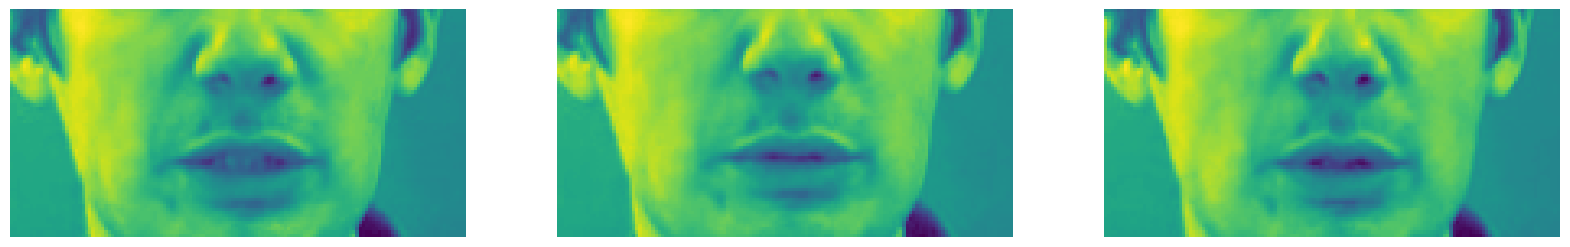

In [28]:
# show the first 10 frames
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for i in range(3):
    ax[i].imshow(frame[i + 45], )
    ax[i].axis('off')  # no axes for this plot

In [6]:
import logging
import os
from typing import List, Tuple
import torch


def load_data(dir) -> List[Tuple[torch.Tensor, torch.Tensor]]:
    data = []
    # 递归搜索该目录下的文件含有align的文件
    alignments = glob.glob(dir + '/**/*.align', recursive=True)
    alignments_dict = {}
    for align in alignments:
        alignments_dict[align.split('/')[-1].split('.')[0]] = load_alignments(align)
    for root, dir, files in os.walk(dir):
        for file in files:
            if file.endswith('.npy'):
                video_frames = np.load(os.path.join(root, file))
                video_frames = torch.from_numpy(video_frames).float()
                filename = file.split('.')[0]
                if filename in alignments_dict:
                    alignments = alignments_dict[filename]
                else:
                    logging.warning(f'No alignment found for {filename}')
                    alignments = ''
                data.append((video_frames, alignments))
    return data


def load_alignments(path: str) -> torch.Tensor:
    with open(path, 'r') as f:
        lines = f.readlines()
        tokens = ''
        for line in lines:
            line = line.split()
            if line[2] != 'sil':
                tokens = tokens + ' ' + line[2]
        tokens_np = np.array([ord(c) for c in tokens])
        tokens_tensor = torch.from_numpy(tokens_np).float()
        return tokens_tensor

In [1]:
import glob


def generate_alignments_text(dir: str) -> set[str]:
    data = []
    # 递归搜索该目录下的文件含有align的文件
    alignments = glob.glob(dir + '/**/*.align', recursive=True)
    for align in alignments:
        with open(align, 'r') as f:
            lines = f.readlines()
            for line in lines:
                line = line.split()
                if line[2] != 'sil':
                    data.append(line[2])
    data = set(data)
    return data


def generate_text() -> set[str]:
    data = generate_alignments_text(dir='/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/')
    # save to a file
    print(len(data))
    with open('text.txt', 'w') as f:
        for item in data:
            f.write("%s " % item)


generate_text()



52


In [33]:
data = load_data('/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data/')
print(data[0][0].shape)

IndexError: list index out of range

In [101]:
print(data[0][1].shape)

torch.Size([22])


In [7]:
def pretain(dir: str) -> List:
    """
    find all the video and extra the mouth region 
    :param dir: 
    :return: 
    """
    video_list = glob.glob(dir + '/**/*.mpg', recursive=True)
    return video_list


In [10]:
video_list = pretain('/home/liazylee/jobs/python/AI/lip_reading/src/lipNet/data')


In [8]:
video_list = pretain('/Users/zhenyili/research project/src/lipNet/data')

In [9]:
print(video_list[:10])

['/Users/zhenyili/research project/src/lipNet/data/s1/prwq3s.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/pbib8p.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/lrae3s.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/pgid6p.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/pbao8n.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/prbx3s.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/lbbk6p.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/bgwu6n.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/sbig6p.mpg', '/Users/zhenyili/research project/src/lipNet/data/s1/pgby5s.mpg']


In [10]:

for i in range(10):
    mouth_extractor(video_list[i])


In [11]:
from config import DIR
from dataset import LRNetDataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Subset
from typing import Any, Tuple


def load_train_test_data() -> list[Subset[Any]]:
    video_dataset = LRNetDataset(DIR)
    train_size = int(0.8 * len(video_dataset))
    test_size = len(video_dataset) - train_size
    return torch.utils.data.random_split(video_dataset, [train_size, test_size])


def collate_fn(batch: list[Tuple[torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor]:
    inputs_tensors, targets_tensors = zip(*batch)
    padded_inputs = pad_sequence(inputs_tensors, batch_first=True, padding_value=0)
    padded_inputs = padded_inputs.permute(0, 4, 1, 2, 3)
    padded_targets = pad_sequence(targets_tensors, batch_first=True, padding_value=0)
    return padded_inputs, padded_targets,


In [14]:

from dataset_loader import LRNetDataLoader

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_dataset, val_dataset = load_train_test_data()
train_loader = LRNetDataLoader(train_dataset, batch_size=32, shuffle=True)

the total alignments files is 1000


In [15]:
sample_inputs, *args = next(iter(train_loader))


In [16]:
sample_inputs, _ = next(iter(train_loader))
print(sample_inputs.shape)
print(_.shape)

torch.Size([8, 3, 75, 70, 140])
torch.Size([8, 29])


In [17]:
input_shape = sample_inputs.shape

print(input_shape)
print(list(map(lambda x: x.shape, args)))

torch.Size([8, 3, 75, 70, 140])
[torch.Size([8, 29])]


In [104]:
input_channels = input_shape[1]
print(input_channels)

1


In [105]:
from model import LRModel
from torch import nn, optim

model = LRModel().to(device)
criterion = nn.CTCLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss_curve, val_loss_curve, train_wer_curve, val_wer_curve = [], [], [], []

In [107]:


from tqdm import tqdm

for epoch in tqdm(range(10)):
    train_loss = 0
    val_loss = 0
    train_wer = 0
    val_wer = 0
    print(f'Epoch {epoch + 1}/{10}')
    for i, (inputs, targets) in enumerate(train_loader):
        # #[32, 75, 1, 70, 140]->[32,1,75,70,140]
        # inputs = torch.permute(inputs, (0, 2, 1, 3, 4))
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.long)
        target_lengths = torch.full(size=(targets.size(0),), fill_value=targets.size(1), dtype=torch.long)
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if i % 10 == 0:
            print(f'Epoch {epoch + 1}/{10}, Step {i}/{len(train_loader)}, Loss: {loss.item():.4f}')
    train_loss /= len(train_loader)
    train_loss_curve.append(train_loss)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10


  0%|          | 0/10 [00:58<?, ?it/s]


KeyboardInterrupt: 

In [6]:
from utils import calculate_cer, calculate_wer

# Example text
reference = "If you have specific test results or details you'd like translated please provide them and I can assist you further."
hypothesis = "If you have specific test results or details you'd like translated please provide them, and I can assist you further"

# Calculate CER
cer = calculate_cer(reference, hypothesis)

# Calculate WER
wer = calculate_wer(reference, hypothesis)

print(type(cer))
print(type(wer))
print(cer)
print(wer)

<class 'float'>
<class 'float'>
0.017241379310344827
0.1


In [1]:
from jiwer import wer, cer

# Your predicted and true strings
predicted = ['', '', '', '', '', '', '', '']
true = ['bin red with n three again', 'bin green with b seven again', 'set green with x four please',
        'place red in c two now', 'set green at p zero now', 'place green with y nine soon',
        'lay white at r eight please', 'bin red at s seven soon']

# Calculate Word Error Rate (WER)
word_error_rate = wer(true, predicted)
print(f"WER: {word_error_rate}")

# Calculate Character Error Rate (CER)
character_error_rate = cer(true, predicted)
print(f"CER: {character_error_rate}")

WER: 1.0
CER: 1.0


In [4]:
from jiwer import wer, cer

text_outputs = [' lae ree it  eie pason', ' lat wree it g eie aon', ' lan wree it g eire ason',
                ' lan wree it g ftie aon', ' lan ree it p eire ason', ' lae wree it g seie aon',
                ' lat wree it e eie ason', ' lat ree it e tie aon']
text_targets = [' set blue by k five again', ' bin white at t five again', ' lay blue at a three soon',
                ' bin blue with x one again', ' place white by t seven again', ' set green in r six now',
                ' lay green with c eight now', ' lay blue at a two now']

wers = [wer(target, output) for target, output in zip(text_targets, text_outputs)]
cers = [cer(target, output) for target, output in zip(text_targets, text_outputs)]
print(wers)
print(cers)
average_wer = sum(wers) / len(wers)
average_cer = sum(cers) / len(cers)
print(average_wer)
print(average_cer)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[0.625, 0.52, 0.4583333333333333, 0.56, 0.6071428571428571, 0.5, 0.46153846153846156, 0.47619047619047616]
1.0
0.526025641025641


In [4]:
import numpy as np
from word_beam_search import WordBeamSearch

corpus = 'a ba'  # two words "a" and "ba", separated by whitespace
chars = 'ab '  # the characters that can be recognized (in this order)
word_chars = 'ab'  # characters that form words

# RNN output
# 3 time-steps and 4 characters per time time ("a", "b", " ", CTC-blank)
mat = np.array([[[0.9, 0.1, 0.0, 0.0]],
                [[0.0, 0.0, 0.0, 1.0]],
                [[0.6, 0.4, 0.0, 0.0]]])

# initialize word beam search (only do this once in your code)
wbs = WordBeamSearch(25, 'Words', 0.0, corpus.encode('utf8'), chars.encode('utf8'), word_chars.encode('utf8'))

# compute label string
label_str = wbs.compute(mat)
print(label_str)
char_str = []  # decoded texts for batch
for curr_label_str in label_str:
    s = ''.join([chars[label] for label in curr_label_str])
    char_str.append(s)
print(char_str)

[[1, 0]]
['ba']


OSError: Cannot read model 'lm/test.arpa' (util/file.cc:76 in int util::OpenReadOrThrow(const char*) threw ErrnoException because `-1 == (ret = open(name, 00))'. No such file or directory while opening /home/liazylee/jobs/python/AI/lip_reading/src/pytorch_lipNet/lm/test.arpa)

In [ ]:
import torch
from ctcdecode import CTCBeamDecoder


def decode_sequences(y_pred, number_dict, beam_search=False, beam_width=10):
    """
    根据模型输出解码序列，可以选择使用贪心解码或束搜索解码。
    
    :param y_pred: 模型输出的logits，形状为(batch_size, timesteps, num_classes)。
    :param number_dict: 包含所有类别的字典，键为类别索引，值为对应字符。
    :param beam_search: 是否使用束搜索解码。默认为False，即使用贪心解码。
    :param beam_width: 束搜索的宽度。默认为10。
    :return: 解码后的序列列表。
    """
    blank_id = 27  # 假设空白标签的索引为27

    if beam_search:
        # 初始化CTCBeamDecoder
        decoder = CTCBeamDecoder([number_dict.get(i, '') for i in range(max(number_dict.keys()) + 1)],
                                 beam_width=beam_width, blank_id=blank_id, log_probs_input=True)
        # 使用CTCBeamDecoder进行解码
        beam_result, _, _, out_lens = decoder.decode(y_pred.permute(1, 0, 2))
        # 处理解码结果
        decoded_sequences = []
        for i in range(beam_result.size(0)):
            seq = beam_result[i, 0, :out_lens[i, 0]]  # 选取得分最高的序列
            decoded_sequences.append(''.join([number_dict.get(x, '') for x in seq]))
    else:
        # 使用贪心解码
        decoded_sequences = []
        _, max_indices = torch.max(y_pred, dim=-1)
        for path in max_indices:
            decoded_sequence = [number_dict.get(path[0].item(), '')]
            for i in range(1, len(path)):
                if path[i] != path[i - 1] and path[i].item() != blank_id:
                    decoded_sequence.append(number_dict.get(path[i].item(), ''))
            decoded_sequences.append(''.join(decoded_sequence))
    return decoded_sequences